## **Reference:**

https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

https://hul980.tistory.com/50?category=933859

… 성공율은 변할 수 있습니다.

하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN이 함께 동작하는 sequence to sequence network 의 간단하지만 강력한 아이디어가 이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고, 디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.


이 모델을 개선하기 위해 Attention Mechanism 을 사용하면 디코더가 입력 시퀀스의 특정 범위에 집중할 수 있도록 합니다.

![seq2seq[1].png](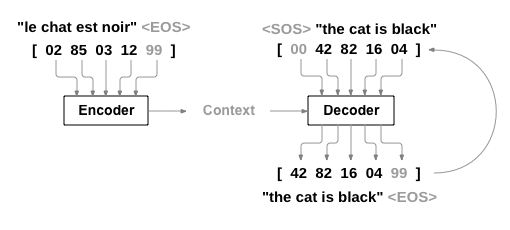)

추천 자료:

최소한 Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다.:

http://pytorch.org/ 설치 안내를 위한 자료
PyTorch로 딥러닝하기: 60분만에 끝장내기 일반적인 PyTorch 시작을 위한 자료
예제로 배우는 파이토치(PyTorch) 넓고 깊은 통찰을 위한 자료
Torch 사용자를 위한 PyTorch 이전 Lua Torch 사용자를 위한 자료
Sequence to Sequence 네트워크와 동작 방법에 관해서 아는 것은 유용합니다:

Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
Sequence to Sequence Learning with Neural Networks
Neural Machine Translation by Jointly Learning to Align and Translate
A Neural Conversational Model
이전 튜토리얼에 있는 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기 와 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기 는 각각 인코더, 디코더 모델과 비슷한 컨센을 가지기 때문에 도움이 됩니다.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import zipfile

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **데이터 다운로드**

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2022-04-18 15:41:35--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.126, 18.160.200.71, 18.160.200.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2022-04-18 15:41:35 (41.5 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
# 전체를 압축해제 하고 싶을 때
zipfile.ZipFile('data.zip').extractall()

**나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다.**

**이 모든 것을 추적하기 위해 우리는 단어→색인(word2index)과 색인→단어(index2word) 사전,**
 
**그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도 word2count 를 가진 Lang 이라는**
 
**헬퍼 클래스를 사용합니다.**

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를 ASCII로 변환하고,**

**모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.**

In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

**많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서 최대 길이는 10 단어 (종료 문장 부호 포함)이며 “I am” 또는 “He is” 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에 아포스트로피는 대체 됨)**

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

**데이터 준비를 위한 전체 과정:**

- **텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.**
- **텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.**
- **쌍을 이룬 문장들로 단어 리스트를 생성합니다.**

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...") 
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['nous allons faire tout ce que nous pouvons .', 'we re going to do everything we can .']


### Seq2Seq Attention Model

seq2seq encoder
- 모든 입력 단어에 대해 벡터와 hidden state 출력 
- 예상으로는 단어 당 hidden state를 반환하고 이를 decoder의 입력으로 넣어 줄 예정

![encoder-network[1].png](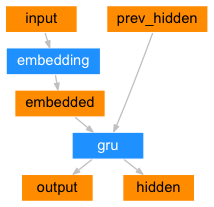)

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN,self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1,1,-1) # 이렇게 선언하는 이유는 batch_size, vocab_len , hidden_state라서 
    output = embedded
    output, hidden = self.gru(output,hidden)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1,1,self.hidden_size, device=device)

### Seq2Seq Attention Model

![attention-decoder-network[1].png](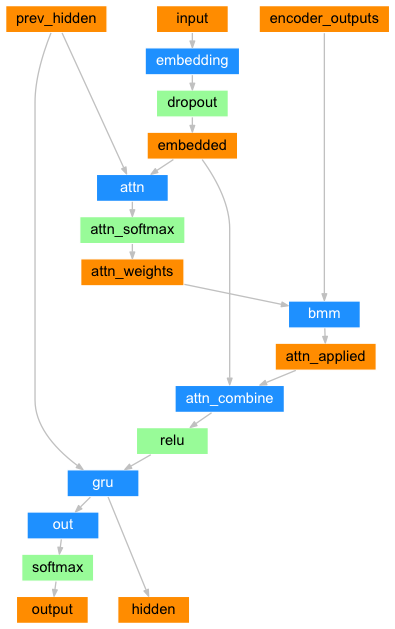)

seq2seq Attention Decoder

- 기존의 경우, context vector만을 가지고 전체 단어를 decode 해야했다면, 지금의 경우는  


In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### **학습 데이터 준비**

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### **Training** 

**“Teacher forcing”은 다음 입력으로 디코더의 예측을 사용하는 대신 실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다. “Teacher forcing”을 사용하면 수렴이 빨리되지만 학습된 네트워크가 잘못 사용될 때 불안정성을 보입니다..**

**Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 “선택” 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.**

**PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로 Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. 더 많이 사용하려면 teacher_forcing_ratio 를 확인하십시오.**

##**Reference :**
https://bo-10000.tistory.com/32

In [ ]:
teacher_forcing_ratio = 0.5

scaler = torch.cuda.amp.GradScaler(enabled = True)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    with torch.cuda.amp.autocast(enabled=True):
      for ei in range(input_length):
          encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
          encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      with torch.cuda.amp.autocast(enabled=True):
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
      with torch.cuda.amp.autocast(enabled=True):
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    scaler.scale(loss).backward()

    scaler.step(encoder_optimizer)
    scaler.step(decoder_optimizer)

    scaler.update()
    
    # encoder_optimizer.step()
    # decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### **결과 도식화**

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### **Evaluation**

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 EOS 토큰을 예측하면 거기에서 멈춥니다. 나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

**학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다**

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

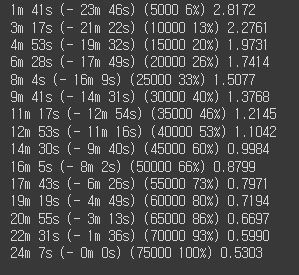

## Mixed Precision 적용 결과 (상)

1m 16s (- 17m 47s) (5000 6%) 2.8483

2m 30s (- 16m 17s) (10000 13%) 2.3169

3m 46s (- 15m 5s) (15000 20%) 2.0179

4m 59s (- 13m 44s) (20000 26%) 1.7353

6m 15s (- 12m 30s) (25000 33%) 1.5565

7m 29s (- 11m 14s) (30000 40%) 1.3947

8m 43s (- 9m 58s) (35000 46%) 1.2306

9m 57s (- 8m 42s) (40000 53%) 1.1176

11m 11s (- 7m 27s) (45000 60%) 1.0326

12m 25s (- 6m 12s) (50000 66%) 0.8755

13m 48s (- 5m 1s) (55000 73%) 0.8463

15m 9s (- 3m 47s) (60000 80%) 0.7561

16m 26s (- 2m 31s) (65000 86%) 0.6910

17m 41s (- 1m 15s) (70000 93%) 0.6069

18m 55s (- 0m 0s) (75000 100%) 0.6056

## Mixed Precision 미적용 결과 (상)

1m 36s (- 22m 25s) (5000 6%) 2.8663

3m 10s (- 20m 38s) (10000 13%) 2.2906

4m 44s (- 18m 57s) (15000 20%) 1.9657

6m 17s (- 17m 18s) (20000 26%) 1.7326

7m 51s (- 15m 42s) (25000 33%) 1.5511

9m 28s (- 14m 13s) (30000 40%) 1.3493

11m 2s (- 12m 37s) (35000 46%) 1.1981

12m 37s (- 11m 2s) (40000 53%) 1.0999

14m 12s (- 9m 28s) (45000 60%) 0.9982

15m 46s (- 7m 53s) (50000 66%) 0.8734

17m 21s (- 6m 18s) (55000 73%) 0.8018

18m 56s (- 4m 44s) (60000 80%) 0.7087

20m 30s (- 3m 9s) (65000 86%) 0.6398

22m 5s (- 1m 34s) (70000 93%) 0.6079

23m 40s (- 0m 0s) (75000 100%) 0.5665

## Mixed Precision 적용 결과 (상)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 36s (- 22m 25s) (5000 6%) 2.8663
3m 10s (- 20m 38s) (10000 13%) 2.2906
4m 44s (- 18m 57s) (15000 20%) 1.9657
6m 17s (- 17m 18s) (20000 26%) 1.7326
7m 51s (- 15m 42s) (25000 33%) 1.5511
9m 28s (- 14m 13s) (30000 40%) 1.3493
11m 2s (- 12m 37s) (35000 46%) 1.1981
12m 37s (- 11m 2s) (40000 53%) 1.0999
14m 12s (- 9m 28s) (45000 60%) 0.9982
15m 46s (- 7m 53s) (50000 66%) 0.8734
17m 21s (- 6m 18s) (55000 73%) 0.8018
18m 56s (- 4m 44s) (60000 80%) 0.7087
20m 30s (- 3m 9s) (65000 86%) 0.6398
22m 5s (- 1m 34s) (70000 93%) 0.6079
23m 40s (- 0m 0s) (75000 100%) 0.5665


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes bizarre .
= you re weird .
< you re weird . <EOS>

> je lis le new york times .
= i m reading the new york times .
< i m reading to my new york . <EOS>

> tu mens mal .
= you re a bad liar .
< you re a bad liar . <EOS>

> tu es le plus vieux .
= you re the oldest .
< you re the oldest . <EOS>

> nous n y sommes pas habituees .
= we re not used to it .
< we re not used to it . <EOS>

> c est un enseignant experimente .
= he is an experienced teacher .
< he is an intelligent teacher . <EOS>

> j entends beaucoup ca ces derniers temps .
= i m hearing that a lot lately .
< i m very concerned with it . <EOS>

> j en ai fini de vous ecouter .
= i m done listening to you .
< i m done to to you . <EOS>

> je n ai pas honte .
= i m not ashamed .
< i m not ashamed . <EOS>

> elle m est etrangere .
= she is a stranger to me .
< she is a to to to me . <EOS>



### **Attention 시각화**

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 plt.matshow(attentions) 를 간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
input = elle est trop petit .
output = she s too short . <EOS>
input = je ne crains pas de mourir .
output = i m not scared to dying . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a talented young person . <EOS>
